In [1]:
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import numpy.typing

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import linear_regression
from linear_regression import LinearRegression

# Helper Functions

In [2]:
def create_orig_df(x, lr):
    '''
    x: design matrix.
    lr: linear regression object.
    '''
    scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
    inds = np.argsort(scores)
    print("inds", inds[:10])
    original_inds = inds # original_inds

    newton_inds = np.argsort(newton_scores)
    print("newton inds", newton_inds[:10])
    original_newton_inds = newton_inds 

    # sort scores.
    sorted_scores = scores[inds]
    print("sorted_scores", sorted(scores)[:10])
    original_sorted_scores = sorted_scores

    sorted_newton_scores = newton_scores[inds]
    print("sorted_newton_scores", sorted_newton_scores[:10])
    original_sorted_newton_scores = sorted_newton_scores

    # residuals
    residuals = lr.residual()
    # print("residuals", residuals[:10])
    # leverages
    leverages = lr.leverage_scores()
    # print("leverages", leverages[:10])

    # x's
    intercept = [pt[0] for pt in x]
    x1 = [pt[1] for pt in x]
    # x2 = [pt[2] for pt in x]

    # x1 = [pt[0] for pt in x]
    # x2 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': scores, 'newton': newton_scores})
    
    print(orig_df[:13])
    
    return orig_df, inds, scores, newton_inds, newton_scores


def create_plot(orig_df):
    '''
    orig_df: output from the helper function above.
    '''
    
    # IV. Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("index 0 in create_plot", sorted_if_df.index[0])
    
    # sorted_if_df # the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    
    sorted_if_df['sorted_idx'] = index
    
    # V. Plot Points Dropped
    plt.figure(figsize=(9, 7))

    plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='x', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B') # pop B


    # Add dropped order positioned by each point
    for index, row in sorted_if_df.iterrows():
        if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
            plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

def plot_dropped_point(x, y, index_to_remove):
    '''
    orig_df: df sorted by original indexing (where the outlier population comes first).
    index_to_drop: index returned from sorting by influence (or one-step newton) scores.
    method: "influence" or "newton"
    '''
    
    # V. Plot Dropped Point at Current Iteration
    plt.figure(figsize=(9, 7))
    plt.scatter(x.T[1][index_to_remove], y[index_to_remove], marker='x', color='black', label='Dropped point')
    
    # match the window of the original plot.
    plt.xlim(-2, 0.05)
    plt.ylim(-7, 3)
    
    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Dropped Point')
    plt.legend()
    
    plt.show()
    
    return


# Generate Data

In [3]:
np.random.seed(0)

# I. Generate the data.
num_dimensions = 1
total_observations = 1010

# NOISE ON X.
eps_pop_1 = 0.25
eps_pop_2 = 0.25 

# Mixing proportions
num_observations_pop_1 = 10 # A (small fraction)
num_observations_pop_2 = total_observations - num_observations_pop_1 # B

mean_pop_1 = np.array([1]) # ADJUST DISTANCE OF OUTLIER CLUMP 4/22: in order for AMIP/Newton to fail, if suffices to 
# adjust the location of the outlier group to be far away, relative to the noise.
mean_pop_2 = np.array([0])

vars_pop_1 = np.array([[eps_pop_1]])
vars_pop_2 = np.array([[eps_pop_2]])


In [4]:
# generate the X values for two populations.
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)
x = np.append(x1, x2, axis=0)
x

array([[ 1.88202617],
       [ 1.2000786 ],
       [ 1.48936899],
       ...,
       [-0.90903882],
       [-0.02466204],
       [ 0.1195168 ]])

In [5]:
# add intercept term. NDArray -> df -> NDArray
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x
# (3/20: make sure that x1, x2 come from this new design matrix.)
x1 = x[:10]
x2 = x[10:]

In [6]:
orig_x = x # (4/01: save this for after running the greedy loop.)

In [7]:
x1_0 = [pt[0] for pt in x1]
x1_1 = [pt[1] for pt in x1]
x2_0 = [pt[0] for pt in x2]
x2_1 = [pt[1] for pt in x2]

In [8]:
# Generating the Y values.
eps1 = 1
epsilon1 = np.random.normal(0, eps1, num_observations_pop_1) # eps is the variance of the outlier distribution.
slope1 = -1 # (-1, -1, 5)
intercept1 = 40 # (-10, 10, 20)
y1 = []
for i in range(num_observations_pop_1):
    y1.append(slope1*x1_1[i] + intercept1 + epsilon1[i]) # May 16: we were indexing the wrong x1 (intercept rather than slope).
    # print(x1_1[i], slope1*x1_1[i], epsilon1[i])

eps2 = 1
epsilon2 = np.random.normal(0, eps2, num_observations_pop_2) # eps is the variance of the outlier distribution.
slope2 = -1
intercept2 = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope2*x2_1[i] + intercept2 + epsilon2[i])

y = np.concatenate([y1, y2], axis=0)

In [9]:
y1

[37.11764347806246,
 40.4739071028271,
 38.6721902751853,
 39.44295814542821,
 37.275697983091945,
 38.58133881841288,
 38.749208012202885,
 37.39699024132019,
 39.26657501652287,
 38.89191998103374]

In [10]:
# II. Fit the regression.
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

# print(
#     f"Estimated intercept with full dataset: {lr.beta[0]}"
# )

modified_lr_a = LinearRegression(x=x1.T, y=y1)
modified_lr_a.fit()
print(
    f"Estimated beta1 pop A: {modified_lr_a.beta[1]}"
)

modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()
print(
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 1.116515051069574
Estimated beta1 pop A: -0.40383763026703057
Estimated beta1 pop B: -0.989510932401851


In [11]:
# III. Compute influence scores for first coefficient.
# scores = -lr.influence_scores()[0] # effect of removing a data point.
scores = -lr.influence_scores()[1] # after adding an intercept term, take the scores of coefficient 1.
newton_scores = -lr.one_step_newton()[1]

print("A", np.mean(np.abs(scores[:10])), "B", np.mean(np.abs(scores[10:1000])))

# sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
inds = np.argsort(scores)
print("inds", inds[:10])
original_inds = inds # original_inds

newton_inds = np.argsort(newton_scores)
print("newton inds", newton_inds[:10])
original_newton_inds = newton_inds 

# sort scores.
sorted_scores = scores[inds]
print("sorted_scores", sorted(scores)[:10])
original_sorted_scores = sorted_scores

sorted_newton_scores = newton_scores[inds]
print("sorted_newton_scores", sorted_newton_scores[:10])
original_sorted_newton_scores = sorted_newton_scores

# residuals
residuals = lr.residual()
print("residuals", residuals[:10])
# leverages
leverages = lr.leverage_scores()
print("leverages", leverages[:10])

# create df
orig_df, inds, scores, newton_inds, newton_scores = create_orig_df(x, lr)
orig_df[:10]

A 0.191343374776504 B 0.0021801720416483802
inds [3 4 0 2 6 1 9 8 7 5]
newton inds [3 4 0 2 6 1 9 8 7 5]
sorted_scores [-0.2976662186943977, -0.25709415985944173, -0.2495336172412997, -0.20920742556768743, -0.20773858345952317, -0.1787143241514191, -0.17212073756003846, -0.13822331853739384, -0.12818693199161135, -0.07494843070222744]
sorted_newton_scores [-0.30321928 -0.26111901 -0.25324541 -0.21123066 -0.20971308 -0.1798995
 -0.17327062 -0.13884883 -0.12874453 -0.07510122]
residuals [34.5867731  38.70444145 36.57972755 36.64588777 34.6870448  37.58083667
 36.67273912 35.93541166 37.77812284 37.1166254 ]
leverages [0.0146569  0.00658801 0.0095783  0.01831367 0.01541386 0.00203439
 0.00941522 0.00433106 0.00450498 0.00663632]
inds [3 4 0 2 6 1 9 8 7 5]
newton inds [3 4 0 2 6 1 9 8 7 5]
sorted_scores [-0.2976662186943977, -0.25709415985944173, -0.2495336172412997, -0.20920742556768743, -0.20773858345952317, -0.1787143241514191, -0.17212073756003846, -0.13822331853739384, -0.128186931991

,x1,y,residual,leverage,influence,newton
0,1.882026,37.117643,34.586773,0.014657,-0.249534,-0.253245
1,1.200079,40.473907,38.704441,0.006588,-0.178714,-0.179900
2,1.489369,38.672190,36.579728,0.009578,-0.209207,-0.211231
3,2.120447,39.442958,36.645888,0.018314,-0.297666,-0.303219
4,1.933779,37.275698,34.687045,0.015414,-0.257094,-0.261119
5,0.511361,38.581339,37.580837,0.002034,-0.074948,-0.075101
6,1.475044,38.749208,36.672739,0.009415,-0.207739,-0.209713
7,0.924321,37.396990,35.935412,0.004331,-0.128187,-0.128745
8,0.948391,39.266575,37.778123,0.004505,-0.138223,-0.138849
9,1.205299,38.891920,37.116625,0.006636,-0.172121,-0.173271


In [12]:
# (4/01) Sum of influence and newton scores for population A
print(f"additive influence score for pop A: {sum(sorted_scores[:10])}")
print(f"additive one-step newton score for pop A: {sum(sorted_newton_scores[:10])}")

print(f'indices sorted according to influence score: {original_inds[:10]}')
print(f'indices sorted according to newton score: {original_newton_inds[:10]}')


additive influence score for pop A: -1.9134337477650398
additive one-step newton score for pop A: -1.9343921278459129
indices sorted according to influence score: [3 4 0 2 6 1 9 8 7 5]
indices sorted according to newton score: [3 4 0 2 6 1 9 8 7 5]


In [13]:
# IV. Sort DF by influence score
sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
# sorted_if_df # the indices here are the order which amip drops points.
index = range(0, len(sorted_if_df))
sorted_if_df['sorted_idx'] = index
sorted_if_df[:10]

,x1,y,residual,leverage,influence,newton,sorted_idx
3,2.120447,39.442958,36.645888,0.018314,-0.297666,-0.303219,0
4,1.933779,37.275698,34.687045,0.015414,-0.257094,-0.261119,1
0,1.882026,37.117643,34.586773,0.014657,-0.249534,-0.253245,2
2,1.489369,38.672190,36.579728,0.009578,-0.209207,-0.211231,3
6,1.475044,38.749208,36.672739,0.009415,-0.207739,-0.209713,4
1,1.200079,40.473907,38.704441,0.006588,-0.178714,-0.179900,5
9,1.205299,38.891920,37.116625,0.006636,-0.172121,-0.173271,6
8,0.948391,39.266575,37.778123,0.004505,-0.138223,-0.138849,7
7,0.924321,37.396990,35.935412,0.004331,-0.128187,-0.128745,8
5,0.511361,38.581339,37.580837,0.002034,-0.074948,-0.075101,9


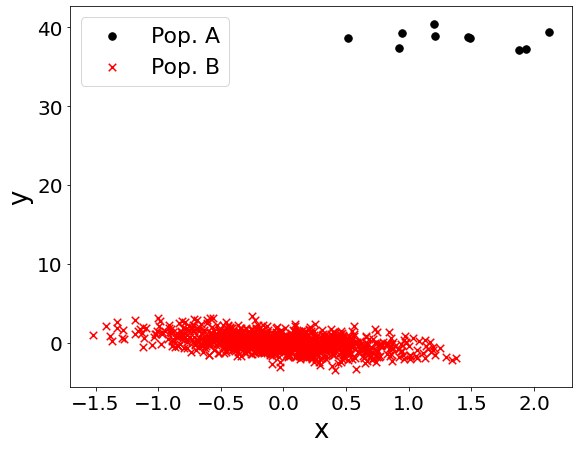

In [15]:
# V. Plot Points Dropped

plt.figure(figsize=(9, 7))

plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A', s=56) # pop A
plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B', s=56) # pop B

plt.xlabel('x', fontsize=26)  # Larger font for x-axis label
plt.ylabel('y', fontsize=26)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=20)  # Larger ticks for x-axis
plt.yticks(fontsize=20)  # Larger ticks for y-axis

# Line of best fit
x_values = np.linspace(min(orig_df['x1']), max(orig_df['x1']), 100) # Define range of x values
y_values = lr.beta[1] * x_values # Calculate corresponding y values based on y = 2x

# plt.plot(x_values, y_values, color='gray', linestyle='--')


# plt.title('Modified Simpson`s Paradox', fontsize=22)
plt.legend(fontsize=22)
plt.savefig('simpsons_paradox_success_data.pdf')
plt.show()

# shift everything up to zero.

We define the failure of an approximation algorithm in two different ways: (i) when there exists a small fraction (alpha < 0.01) of data (which is user-predefined) that we can drop to change conclusions, yet the algorithm reports such a fraction does not exist or (ii) if there exists a small fraction of data that we can drop to change conclusions, and we remove the points suggested by the algorithm, but we do not see a change in conclusions. The second definition is motivated by the person who is willing to run their algorithm twice, such that even when the algorithm does not report a change in conclusions, the user is willing to rerun their analysis by removing the points suggested by the algorithm.

We illustrate Simpson's paradox as a realistic data setting under which AMIP and 1sN may fail. This example is set up with two populations of points. Population A consisted of $<1%$ of the datapoints. The DGP for population A is $X \sim N(5, 0.01)$ and $Y = -X + 20 + \epsilon$, while that of population B is $X \sim N(0, 0.01)$ and $Y = -X + \epsilon$, where $\epsilon \sim N(0, 1)$.

The regression on population A is $Y = -X + 20 + \epsilon$ while that of population B is $Y = -X + \epsilon$, where $\epsilon \sim N(0, 1)$. In this example, dropping only the 10 datapoints in population A suffices to flip the effect size of the regression from 2.82 to -1.05.

We observe that AMIP fails in both the type (i) and type (ii) sense. That is, AMIP approximates that the largest effect size for the removal of 10 datapoints is -0.149 (failure type i), which is not enough to change the sign. In addition, AMIP fails to correctly identify subset A as the correct subset to remove (failure type ii). Similarly, 1sN fails in this case. That is, 1sN approximates that the largest effect size for the removal of 10 datapoints is -0.165 (failure type i). 1sN also fails to correctly identify subset A as the correct subset to remove (failure type ii). In running the greedy versions of these algorithms on this Simpson's paradox example, we find that both greedy AMIP and greedy 1sN are able to succeed in identifying population A as an influential subset that reverses the sign.


# Eigenvectors: Mechanism For Failure

In [16]:
def normalize_vector(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v 
    return v / norm

In [17]:
# compute (xtxinv - x2tx2inv)
xtxinv = np.linalg.inv(x.T @ x)
x2tx2inv = np.linalg.inv(x2.T @ x2)
M = xtxinv - x2tx2inv

In [18]:
M

array([[-1.21509368e-05, -6.15166560e-05],
       [-6.15166560e-05, -3.41555313e-04]])

In [19]:
# compute the Singular Value Decomposition
U, s, V = np.linalg.svd(M)
print(f'eigenvalues: {s}')

# The operator norm is the largest singular value
normM = np.max(s)
print(normM)

largest_eigenvector = U[:, 0] # Success Mode: Largest eigenvalue is 4.00e-03.
second_eigenvector = U[:, 1]

print(largest_eigenvector)

eigenvalues: [3.52668681e-04 1.03756888e-06]
0.00035266868107193544
[-0.17777848 -0.98407053]


In [20]:
### Compute the Error Vector.
x1y1 = x1.T @ y1
Sigma_s = x1.T @ x1
Sigma_inv = np.linalg.inv(x.T @ x)
xty = x.T @ y

In [21]:
error_vec = x1y1 - Sigma_s @ Sigma_inv @ Sigma_s @ xty

In [22]:
norm_error_vec = normalize_vector(error_vec)
norm_error_vec

array([-0.50663729, -0.8621593 ])

In [23]:
largest_ev_dot_error_vec=largest_eigenvector.T @ norm_error_vec
largest_ev_dot_error_vec

0.9384947675476621

## Verifying Error Term Expression (June 25th)

In [24]:
import math

# empirical error: beta(w) - beta^{IF}(w) 
beta_w = modified_lr.beta[1]
beta_IF_w = lr.beta[1] + sum(scores[:10])
print(beta_IF_w - beta_w)

# Xs^Trs = (\sum_i r_i , \sum_i xiri)
rs = (y1 - x1 @ lr.beta)
rs
xstrs = x1.T @ rs
xstrs

# analytic error: etM2v
print(-M[1:2] @ xstrs)

# print norm values
print('norm M:', np.linalg.norm(M[1:2]))
print('norm v:', np.linalg.norm(xstrs))  

# normed vectors
norm_m_vec = normalize_vector(-M[1:2])[0]
norm_v_vec = normalize_vector(xstrs)

# cosine similarity
costheta = norm_m_vec @ norm_v_vec
theta = math.acos(costheta) * (180.0 / math.pi)
print('theta in degrees:', theta)

# new June 25th - should be the same as the old.
print(norm_m_vec)
print(norm_v_vec)

0.19259223570638517
[0.19259224]
norm M: 0.00034705090538347555
norm v: 618.1167141466302
theta in degrees: 26.130831836091122
[0.17725543 0.98416488]
[0.59258648 0.80550683]


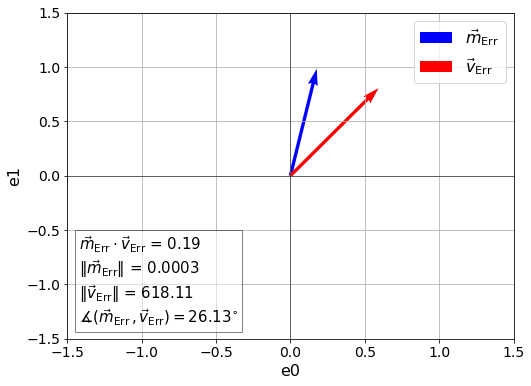

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
# v1 = np.array([-1.42243630e-04, -3.99934473e-03]) # M[:, 1]
v1 = norm_m_vec
# v2 = np.array([[-0.03937332, -0.99922457]]) # error vector
v2 = norm_v_vec

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color="blue", label=r'$\vec{m}_{\mathrm{Err}}$')
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color="red", label=r'$\vec{v}_{\mathrm{Err}}$')

textstring = '\n'.join((
    r'$\vec{m}_{\mathrm{Err}} \cdot \vec{v}_{\mathrm{Err}}$ = 0.19',
    r'$\|\vec{m}_{\mathrm{Err}}\|$ = 0.0003',
    r'$\|\vec{v}_{\mathrm{Err}}\|$ = 618.11',
    r'$\measuredangle{ (\vec{m}_{\mathrm{Err}}\, , \vec{v}_{\mathrm{Err}}) } = 26.13^{\circ} $'
)) 

# Adding a text box
plt.text(-1.42, -1.36, textstring, fontsize = 15, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

# Setting the limits and labels
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

# plt.title('Modified Simpson`s Paradox Example', fontsize=22)
plt.legend(fontsize=16)

# plt.savefig('simpsons_paradox_success_vector_june25.pdf')
plt.savefig('mv.simpsons.success.pdf')
plt.show()

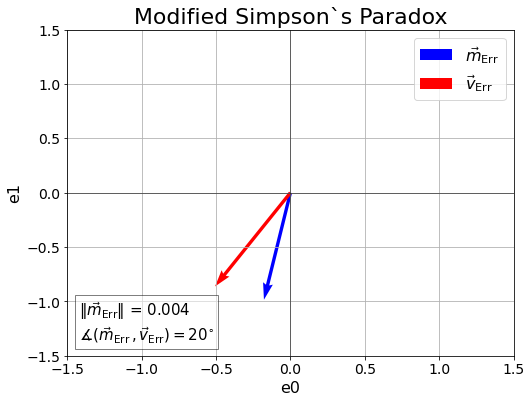

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
# v1 = np.array([-5.06276549e-06, -1.42243630e-04])
# v2 = np.array([-1.42243630e-04, -3.99934473e-03])
v1 = largest_eigenvector
v2 = norm_error_vec

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color="blue", label=r'$\vec{m}_{\mathrm{Err}}$')
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color="red", label=r'$\vec{v}_{\mathrm{Err}}$')

textstring = '\n'.join((
    r'$\|\vec{m}_{\mathrm{Err}}\|$ = 0.004',
    r'$\measuredangle{ (\vec{m}_{\mathrm{Err}}\, , \vec{v}_{\mathrm{Err}}) } = 20^{\circ} $'
))

# Adding a text box
plt.text(-1.42, -1.36, textstring, fontsize = 15, 
         bbox = dict(facecolor = 'white', alpha = 0.5))


# Setting the limits and labels
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

plt.title('Modified Simpson`s Paradox', fontsize=22)
plt.legend(fontsize=16)

plt.savefig('simpsons_paradox_success_vector_june25.pdf')
plt.show()

### Why is it the case that the eigenvector corresponding to the largest eigenvalue is always approximately M_{row 2}?

In [29]:
M
M_norm = normalize_vector(M)
M_norm

array([[-0.03445411, -0.17443111],
       [-0.17443111, -0.9684836 ]])

In [30]:
largest_eigenvector

array([-0.17777848, -0.98407053])

In [31]:
# compute the Singular Value Decomposition
U, s, V = np.linalg.svd(M)
print(f'eigenvalues: {s}')

# The operator norm is the largest singular value
normM = np.max(s)
print(normM)

largest_eigenvector = U[:, 0] # Simpson's Paradox: Largest eigenvalue is 4.00e-03.
second_eigenvector = U[:, 1]

print(largest_eigenvector)

eigenvalues: [3.52668681e-04 1.03756888e-06]
0.00035266868107193544
[-0.17777848 -0.98407053]


In [32]:
### Compute the Error Vector.
x1y1 = x1.T @ y1
Sigma_s = x1.T @ x1
Sigma_inv = np.linalg.inv(x.T @ x)
xty = x.T @ y

In [33]:
error_vec = x1y1 - Sigma_s @ Sigma_inv @ Sigma_s @ xty

In [34]:
norm_error_vec = normalize_vector(error_vec)
norm_error_vec

array([-0.50663729, -0.8621593 ])

Simpson's paradox: the largest eigenvector aligns closely with Xsys

In [35]:
largest_ev_dot_error_vec=largest_eigenvector.T @ norm_error_vec
largest_ev_dot_error_vec

0.9384947675476621

In [36]:
# second_ev_dot_x1y1=second_eigenvector.T @ norm_x1y1
# second_ev_dot_x1y1
# second_ev_dot_x2y2=second_eigenvector.T @ norm_x2y2
# second_ev_dot_x2y2

In [37]:
second_ev_dot_error_vec=second_eigenvector.T @ norm_error_vec
second_ev_dot_error_vec

0.34529345676635703

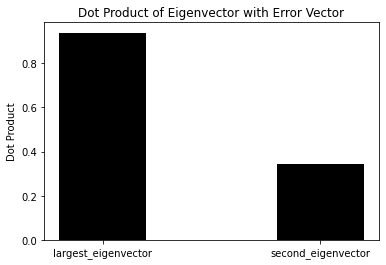

In [38]:
import matplotlib.pyplot as plt

# Values from the outputs related to dot products
eigenvalues = [largest_ev_dot_error_vec, second_ev_dot_error_vec]
eigenvectors = ['largest_eigenvector', 'second_eigenvector']

# Creating the bar plot with thinner bars
plt.bar(eigenvectors, eigenvalues, color=['black', 'black'], width=0.4)  # Adjust the width here
plt.ylabel('Dot Product')
plt.title('Dot Product of Eigenvector with Error Vector')
plt.savefig('simpsons_barplot.pdf')
plt.show()

We illustrate Multicollinearity as another data setting under which AMIP and 1sN may fail. This example is also set up with two populations of points. Population A consisted of $<1%$ of the datapoints. The DGP for population A is $X \sim N(-1, 0.01)$ and $Y = -5X - 10 + \epsilon$, while that of population B is $X \sim N(0, 0.001)$ and $Y = -X + \epsilon$, where $\epsilon \sim N(0, 1)$.


In [39]:
print(
    f"Condition number of full dataset: {np.linalg.cond(x)}"
)

print(
    f"Condition number Pop A: {np.linalg.cond(x1)} Pop B: {np.linalg.cond(x2)}"
)

Condition number of full dataset: 1.9617093614469026
Condition number Pop A: 6.268069735836706 Pop B: 2.0390310495837616


# Why does the error vector align with the largest eigenvector of the diff in inverse hessians?

notice that the largest eigenvector aligns well with the vector e1 = (0, 1). this is why the error is large in x, but is it large in the intercept?

This is because Xs^Trs = (\sum r_i , \sum r_i x_i). In order for Xs^Trs \approx (0, 1), and more generally (0, 1, 0, 0, 0) when our axis of interest is ei, we must have that \sum r_i x_i >> \sum r_i x_j. This means that the reason this counterexample is happening is because the outlier blob has super large (xi values) (in the case where the inliers are mean-centered, it means they are far from the inlier blob in the ei direction, relative to the other directions.)

In [40]:
M

array([[-1.21509368e-05, -6.15166560e-05],
       [-6.15166560e-05, -3.41555313e-04]])

In [41]:
# compute the Singular Value Decomposition
U, s, V = np.linalg.svd(M)
print(f'eigenvalues: {s}')
print(U)

# The operator norm is the largest singular value
normM = np.max(s)
# print(s)

largest_eigenvector = U[:, 0] # Simpson's Paradox: Largest eigenvalue is 4.00e-03.
second_eigenvector = U[:, 1]

eigenvalues: [3.52668681e-04 1.03756888e-06]
[[-0.17777848 -0.98407053]
 [-0.98407053  0.17777848]]


In [42]:
# vector norm of M[:, 1]
np.sqrt(M[0,1]**2 + M[1,1]**2)

0.00034705090538347555

In [43]:
# vector norm of M[:, 0]
np.sqrt(M[0,0]**2 + M[1,0]**2)

6.270521693379057e-05

In [44]:
M1_norm = normalize_vector(M[:,1])
M1_norm

array([-0.17725543, -0.98416488])

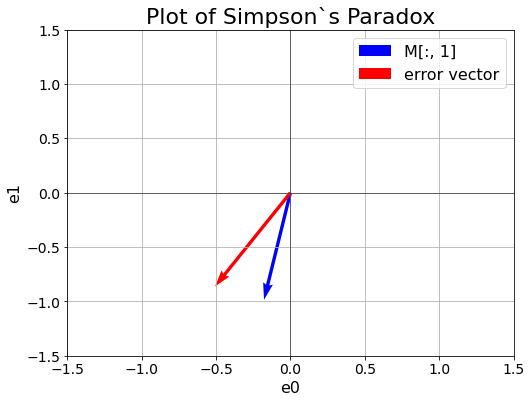

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
# v1 = np.array([-1.42243630e-04, -3.99934473e-03]) # M[:, 1]
v1 = M1_norm
# v2 = np.array([[-0.03937332, -0.99922457]]) # error vector
v2 = norm_error_vec

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color="blue", label="M[:, 1]")
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color="red", label="error vector")

# Setting the limits and labels
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

plt.title('Plot of Simpson`s Paradox', fontsize=22)
plt.legend(fontsize=16)
plt.show()

In [46]:
# Xs^Trs = (\sum_i r_i , \sum_i xiri)
rs = (y1 - x1 @ lr.beta)
rs
xstrs = x1.T @ rs
xstrs

array([366.28761036, 497.89723719])

In [47]:
rs

array([34.5867731 , 38.70444145, 36.57972755, 36.64588777, 34.6870448 ,
       37.58083667, 36.67273912, 35.93541166, 37.77812284, 37.1166254 ])

In [48]:
x1[:, 1] *  rs

array([65.09321221, 46.44837207, 54.48071195, 77.70564812, 67.07707864,
       19.21737648, 54.09391146, 33.21586987, 35.82841561, 44.73664079])

In [49]:
x1[:, 1] 

array([1.88202617, 1.2000786 , 1.48936899, 2.1204466 , 1.933779  ,
       0.51136106, 1.47504421, 0.9243214 , 0.94839057, 1.20529925])

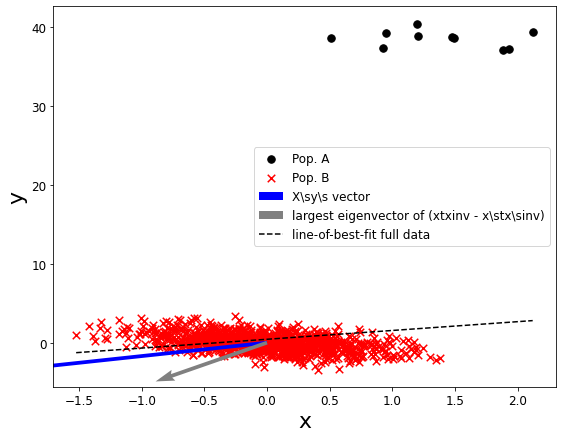

In [50]:
# V. Plot Points Dropped

plt.figure(figsize=(9, 7))

plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A', s=56) # pop A
plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B', s=56) # pop B

plt.xlabel('x', fontsize=22)  # Larger font for x-axis label
plt.ylabel('y', fontsize=22)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=12)  # Larger ticks for x-axis
plt.yticks(fontsize=12)  # Larger ticks for y-axis

plt.xlabel('x')
plt.ylabel('y')

# Line of best fit
x_values = np.linspace(min(orig_df['x1']), max(orig_df['x1']), 100) # Define range of x values
y_values = lr.beta[1] * x_values + lr.beta[0] # Calculate corresponding y values based on y = 2x

# Define the vector x\sy\s
vector_x = 5*norm_error_vec[0] 
vector_y = 5*norm_error_vec[1] 

# Plot the vector starting from the origin (0,0)
plt.quiver(0, 0, vector_x, vector_y, angles='xy', scale_units='xy', scale=1, color='blue', label='X\sy\s vector')

# Define the vector largest_eigenvector
eigvec_x = 5*largest_eigenvector[0] 
eigvec_y = 5*largest_eigenvector[1] 

# Plot the vector starting from the origin (0,0)
plt.quiver(0, 0, eigvec_x, eigvec_y, angles='xy', scale_units='xy', scale=1, color='gray', 
           label='largest eigenvector of (xtxinv - x\stx\sinv)')



plt.plot(x_values, y_values, color='black', linestyle='--', label='line-of-best-fit full data')
plt.legend(fontsize=12)
# plt.savefig('simpsons_may17.pdf')
# plt.savefig('simpsons_may18.pdf')

plt.show()

### Operator Norm of M
Largest eigenvalue is 4.00e-03

### Cos(theta)
the cosine similarity between the largest eigenvector and the error vector is 0.99.

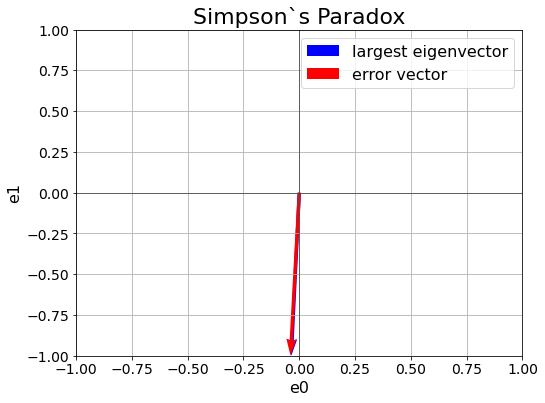

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
v1 = np.array([-0.03554429, -0.9993681])
v2 = np.array([-0.03937332, -0.99922457])

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color="blue", label="largest eigenvector")
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color="red", label="error vector")

# Setting the limits and labels
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

plt.title('Simpson`s Paradox', fontsize=22)
plt.legend(fontsize=16)
plt.savefig('simpsons_paradox_vector_plot.pdf')
plt.show()